## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner
import glob
import re
import seaborn as sns

import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
from scipy.stats import gaussian_kde
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
import gwpopulation as gwpop
from gwpopulation.models import mass, spin, redshift

from bilby.core.utils import logger
from gwpopulation import vt
from gwpopulation.cupy_utils import xp, to_numpy, trapz
from bilby.hyper.model import Model

xp = gwpop.cupy_utils.xp

In [2]:
result = bilby.result.read_in_result("Results/O3a_Shanika_extended_results/O3a_Shanika_extended_results.json")

In [3]:
df = result.posterior
df

,alpha,beta,mmax,mmin,mu_chi,sigma_chi,lambda_chi_peak,xi_spin,sigma_spin,zmin,lamb,amax,log_likelihood,log_prior
0,2.819348,9.203789,61.664006,5.655365,0.279574,0.034540,0.901450,0.221382,1.332881,-0.286522,2.047631,1.0,27.122334,-13.702812
1,1.803674,10.211782,87.899292,3.122192,0.363551,0.038527,0.712375,0.810650,1.658700,0.149083,-1.927811,1.0,29.001139,-13.702812
2,2.482685,10.320216,82.310407,4.322599,0.578839,0.012418,0.929532,0.055839,3.841259,-0.648306,-0.989270,1.0,29.563074,-13.702812
3,2.059557,0.010323,98.830378,2.726013,0.610611,0.059098,0.707594,0.048072,3.625795,-0.347258,-1.574113,1.0,29.931275,-13.702812
4,2.121092,1.311132,97.113712,7.032034,0.592601,0.044961,0.804016,0.846214,3.836982,0.724643,-1.673079,1.0,30.291875,-13.702812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7143,2.218063,2.096763,72.316844,6.220879,0.445914,0.035609,0.797910,0.465309,3.664272,0.260184,0.358233,1.0,42.967317,-13.702812
7144,2.230944,1.834049,76.185472,6.501808,0.545050,0.018286,0.795115,0.549014,3.699713,0.018298,0.565475,1.0,42.972596,-13.702812
7145,2.230944,1.834049,76.185472,6.501808,0.545050,0.018286,0.795115,0.549014,3.699713,0.018298,0.565475,1.0,42.972596,-13.702812
7146,2.438652,1.573023,71.335348,5.631269,0.462003,0.020855,0.805159,0.488203,0.012759,0.058703,0.624621,1.0,43.010904,-13.702812


In [4]:
ii = df[["log_likelihood"]].idxmax()
df["log_likelihood"][ii].item()

43.12459401604599

In [5]:
def conversion(m, n):
    mu = m
    var = n
    r = (mu ** 2 * (1 - mu) - mu * var) / var
    s = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return r, s

In [6]:
# spin-magnitude conversion

max_mu_chi = df["mu_chi"][ii].item()
max_sigma_chi = df["sigma_chi"][ii].item()
max_lambda_chi_peak = df["lambda_chi_peak"][ii].item()

print(max_mu_chi, max_sigma_chi, max_lambda_chi_peak)

max_alpha_chi, max_beta_chi = conversion(max_mu_chi, max_sigma_chi)
print(max_alpha_chi)
print(max_beta_chi)

0.6291653082294512 0.029509636837799474 0.8593877134134625
4.345295650964537
2.5611494344975583


### Trial 1 -- Spin Mangnitude

In [7]:
def beta_dist(xx, alpha, beta, scale=1):

    if alpha < 0:
        raise ValueError(f"Parameter alpha must be greater or equal zero, low={alpha}.")
    if beta < 0:
        raise ValueError(f"Parameter beta must be greater or equal zero, low={beta}.")
    ln_beta = (alpha - 1) * np.log(xx) + (beta - 1) * np.log(scale - xx)
    ln_beta -= betaln(alpha, beta)
    ln_beta -= (alpha + beta - 1) * np.log(scale)
    prob = np.exp(ln_beta)
    prob = np.nan_to_num(prob)
    prob *= (xx >= 0) * (xx <= scale)
    return prob

def truncnorm(xx, mu, sigma, high, low):

    if sigma <= 0:
        raise ValueError(f"Sigma must be greater than 0, sigma={sigma}")
    norm = 2 ** 0.5 / np.pi ** 0.5 / sigma
    norm /= erf((high - mu) / 2 ** 0.5 / sigma) + erf((mu - low) / 2 ** 0.5 / sigma)
    prob = np.exp(-np.power(xx - mu, 2) / (2 * sigma ** 2))
    prob *= norm
    prob *= (xx <= high) & (xx >= low)
    return prob

In [8]:
from scipy.special._ufuncs import erf, btdtri, betaln
from scipy.special import erfinv

class ExtendedSpinMagnitude(bilby.core.prior.Prior):
    """Define a new prior class where p(a) = (1 - lambda_chi_peak) Beta(a | alpha, beta) + 
                                             lambda_chi_peak * G_t(a | mu = 0, sigma_chi_peak = 0)"""
    
    def __init__(self, alpha_chi, beta_chi, lambda_chi_peak, sigma_chi_peak, amax, minimum, 
                 maximum, name=None, latex_label=None):
        super(ExtendedSpinMagnitude, self).__init__(name=name, latex_label=latex_label, minimum=minimum, 
                                                    maximum=maximum)
        self.alpha_chi = alpha_chi
        self.beta_chi = beta_chi
        self.lambda_chi_peak = lambda_chi_peak
        self.sigma_chi_peak = sigma_chi_peak
        self.amax = amax
        self.mu = 0
        
    @property
    def normalisation(self):
        """ Calculates the proper normalisation of the truncated Gaussian """
        
        return (erf((self.amax - self.mu) / 2 ** 0.5 / self.sigma_chi_peak) - 
                erf((0 - self.mu) / 2 ** 0.5 / self.sigma_chi_peak)) / 2
        
        
    def rescale(self, val):
        
        beta_rescale = (1-self.lambda_chi_peak) * (btdtri(self.alpha_chi, self.beta_chi, val) * 
                                                   (self.maximum - self.minimum) + self.minimum)
        
        if self.sigma_chi_peak == 0:
            delta_rescale = self.lambda_chi_peak * self.mu * val ** 0
            
            return (beta_rescale + delta_rescale)
        
        else:
            trunc_gauss_rescale = self.lambda_chi_peak * (erfinv(2 * val * self.normalisation + 
                                                                 erf((0 - self.mu) / 2 ** 0.5 / 
                                                                     self.sigma_chi_peak)) 
                                                          * 2 ** 0.5 * self.sigma_chi_peak + self.mu)
            return (beta_rescale + trunc_gauss_rescale)
        
    def prob(self, val):
        
        in_prior = (val >= self.minimum) & (val <= self.maximum)
        beta_prob = (1-self.lambda_chi_peak)* beta_dist(val, self.alpha_chi, self.beta_chi, scale = self.amax)
        
        if self.sigma_chi_peak == 0:
            at_peak = (val == self.mu)
            delta_prob = self.lambda_chi_peak * np.nan_to_num(np.multiply(at_peak, np.inf))
            
            return (beta_prob + delta_prob) * in_prior
        
        else:
            trunc_gauss_prob = self.lambda_chi_peak * truncnorm(val, mu = self.mu, sigma = self.sigma_chi_peak, 
                                                            low = 0, high = self.amax)
            return (beta_prob + trunc_gauss_prob) * in_prior

In [15]:
data = PriorDict()

# spin-magnitude
data["a_1"] = ExtendedSpinMagnitude(alpha_chi = max_alpha_chi, beta_chi = max_beta_chi, 
                                    lambda_chi_peak = max_lambda_chi_peak, 
                                    sigma_chi_peak = 0, amax = 1, minimum = 0, maximum = 1, 
                                    name='a_1', latex_label = r'$\chi_{\mathrm{1}}$')
data["a_2"] = ExtendedSpinMagnitude(alpha_chi = max_alpha_chi, beta_chi = max_beta_chi, 
                                    lambda_chi_peak = max_lambda_chi_peak, 
                                    sigma_chi_peak = 0, amax = 1, minimum = 0, maximum = 1,  
                                    name='a_2', latex_label = r'$\chi_{\mathrm{2}}$')

In [16]:
dff = pd.DataFrame(data.sample(100000))
dff

,a_1,a_2
0,0.081395,0.047336
1,0.105135,0.061205
2,0.100831,0.084322
3,0.103167,0.128148
4,0.100978,0.098311
...,...,...
99995,0.057797,0.095990
99996,0.111541,0.105773
99997,0.078163,0.058767
99998,0.105102,0.084153


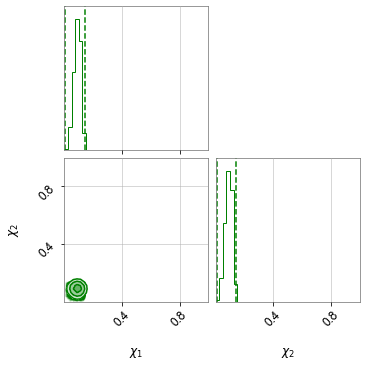

In [17]:
params = ['a_1','a_2']
labels = ["$\\chi_{1}$", "$\\chi_{2}$"]

data1 = dff[params].values

figure1 = corner.corner(data1,color="g",bins=40, smooth=0.9, label_kwargs=dict(fontsize=12), 
                    title_kwargs=dict(fontsize=20),quantiles=[0, 1],
                    plot_density=False, plot_datapoints=True, fill_contours=True,
                    max_n_ticks=3, labels=labels, range = [(0, 1), (0, 1)], hist_kwargs=dict(density=True))

### Trial - 2 -- Spin Magnitude

In [16]:
def iid_spin_magnitude_beta_truncated_gaussian(dataset, amax=1, alpha_chi=1, beta_chi=1, lambda_chi_peak=0, sigma_chi_peak=0):

    return independent_spin_magnitude_beta_truncated_gaussian(
        dataset, alpha_chi, alpha_chi, beta_chi, beta_chi, amax, amax, lambda_chi_peak, lambda_chi_peak, sigma_chi_peak, sigma_chi_peak)

def independent_spin_magnitude_beta_truncated_gaussian(
    dataset, alpha_chi_1, alpha_chi_2, beta_chi_1, beta_chi_2, amax_1, amax_2, lambda_chi_peak_1, lambda_chi_peak_2, sigma_chi_peak_1, sigma_chi_peak_2):
 
    if alpha_chi_1 < 0 or beta_chi_1 < 0 or alpha_chi_2 < 0 or beta_chi_2 < 0:
        return 0
    
    if (sigma_chi_peak_1 == 0 or sigma_chi_peak_2 == 0):
        prior = (
            (1 - lambda_chi_peak_1) * beta_dist(dataset["a_1"], alpha_chi_1, beta_chi_1, scale=amax_1)
                 + lambda_chi_peak_1 * np.nan_to_num(np.multiply((dataset["a_1"] == 0), np.inf))
        ) * (
            (1 - lambda_chi_peak_2) * beta_dist(dataset["a_2"], alpha_chi_2, beta_chi_2, scale=amax_2)
                 + lambda_chi_peak_2 * np.nan_to_num(np.multiply((dataset["a_2"] == 0), np.inf))
        )
        
    else:
        prior = (
            (1 - lambda_chi_peak_1) * beta_dist(dataset["a_1"], alpha_chi_1, beta_chi_1, scale=amax_1) 
            + lambda_chi_peak_1 * truncnorm(dataset["a_1"], mu=0, sigma=sigma_chi_peak_1, low=0, high=amax_1)
        ) * (
            (1 - lambda_chi_peak_2) * beta_dist(dataset["a_2"], alpha_chi_2, beta_chi_2, scale=amax_2) 
            + lambda_chi_peak_2 * truncnorm(dataset["a_2"], mu=0, sigma=sigma_chi_peak_2, low=0, high=amax_2)
        )

    return prior

In [ ]:
model = Model([iid_spin_magnitude_beta_truncated_gaussian])

In [ ]:
mags = np.linspace(0, 1, 1000)
a_1, a_2 = np.meshgrid(mags, mags)
parameters = {
    'alpha_chi'        : max_alpha_chi,
    'beta_chi'         : max_beta_chi,
    'amax'             : 1,
    'lambda_chi_peak'  : max_lambda_chi_peak,
    'sigma_chi_peak'   : 0
}
data = dict(a_1=a_1, a_2=a_2)
model.parameters.update(parameters)
prob = model.prob(data)
a_1_prob = trapz(prob, mags, axis=0)
a_2_prob = trapz(prob, mags, axis=-1)


In [17]:
import deepdish as dd
import os

def spin_magnitude_spectrum_plot(results, limits, rate=False, save=True):
    mags = xp.linspace(0, 1, 1000)
    a_1, a_2 = xp.meshgrid(mags, mags)
    model = Model([independent_spin_magnitude_beta])

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for result in results:
        filename = f"{result.outdir}/{result.label}_magnitude_data.h5"
        if os.path.isfile(filename):
            _data = dd.io.load(filename)
            lines = _data["lines"]
            ppd = _data["ppd"]
        else:
            for key in ["amax", "mu_chi", "sigma_chi", "lambda_chi_peak", "sigma_chi_peak"]:
                if f"{key}_1" not in result.posterior:
                    result.posterior[f"{key}_1"] = result.posterior[key]
                    result.posterior[f"{key}_2"] = result.posterior[key]
                    del result.posterior[key]

            data = dict(a_1=a_1, a_2=a_2)
            lines = dict(a_1=list(), a_2=list())
            ppd = xp.zeros_like(data["a_1"])

            result.posterior = convert_to_beta_parameters(result.posterior)[0]

            if len(result.posterior) > MAX_SAMPLES:
                samples = result.posterior.sample(MAX_SAMPLES)
            else:
                samples = result.posterior

            for ii in tqdm(range(len(samples))):
                parameters = dict(samples.iloc[ii])
                model.parameters.update(parameters)
                prob = model.prob(data)
                if rate:
                    if "rate" not in parameters:
                        rate = False
                    else:
                        prob *= parameters["rate"]
                ppd += prob

                a_1_prob = trapz(prob, mags, axis=0)
                a_2_prob = trapz(prob, mags, axis=-1)

                lines["a_1"].append(a_1_prob)
                lines["a_2"].append(a_2_prob)
            for key in lines:
                lines[key] = np.vstack([to_numpy(line) for line in lines[key]])

            ppd /= len(samples)
            ppd = to_numpy(ppd)
            dd.io.save(filename, data=dict(lines=lines, ppd=ppd))

        mags = to_numpy(mags)

        a_1_ppd = np.trapz(ppd, mags, axis=0)
        a_2_ppd = np.trapz(ppd, mags, axis=1)

        label = " ".join(result.label.split("_")).title()

        axs[0].plot(mags, a_1_ppd, label=label)
        axs[0].fill_between(
            mags,
            np.percentile(lines["a_1"], limits[0], axis=0),
            np.percentile(lines["a_1"], limits[1], axis=0),
            alpha=0.5,
        )
        axs[1].plot(mags, a_2_ppd)
        axs[1].fill_between(
            mags,
            np.percentile(lines["a_2"], limits[0], axis=0),
            np.percentile(lines["a_2"], limits[1], axis=0),
            alpha=0.5,
        )

    for ii in [1, 2]:
        axs[ii - 1].set_xlim(0, 1)
        axs[ii - 1].set_ylim(0)
        axs[ii - 1].set_xlabel(f"$a_{ii}$")
        if rate:
            ylabel = f"$\\frac{{dN}}{{da_{ii}}}$"
        else:
            ylabel = f"$p(a_{ii})$"
        axs[ii - 1].set_ylabel(ylabel)
    axs[0].legend(loc="best")

    if len(results) == 1:
        file_name = f"{result.outdir}/{result.label}_magnitude_spectrum.pdf"
    else:
        file_name = f"{result.outdir}/comparison_magnitude_spectrum.pdf"
    plt.tight_layout()
    if save:
        plt.savefig(file_name, format="pdf", dpi=600)
        plt.close()
        return ppd
    else:
        return fig


KeyError: 'sigma_chi_peak'

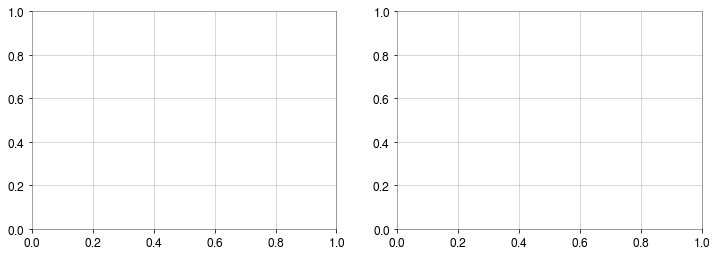

In [18]:
spin_magnitude_spectrum_plot([result], (0,1), rate=False, save=True)

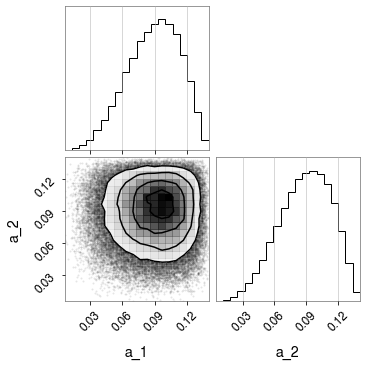

In [14]:
figure = corner.corner(dff)

In [ ]:
def prior_conversion1(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return parameters

def prior_conversion2(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    added_keys = pd.DataFrame()
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    added_keys["alpha_chi"] = parameters["alpha_chi"]
    added_keys["beta_chi"] = parameters["beta_chi"]
    return parameters, added_keys

In [ ]:
priors = PriorDict(conversion_function = prior_conversion1)

# mass
priors["alpha"] = df["alpha"][ii]
priors["beta"] = df["beta"][ii]
priors["mmin"] = df["mmin"][ii]
priors["mmax"] = df["mmax"][ii]

# spin magnitude 
priors["mu_chi"] = df["mu_chi"][ii]
priors["sigma_chi"] = df["sigma_chi"][ii]
priors["lambda_chi_peak"] = df["lambda_chi_peak"][ii]
priors["sigma_chi_peak"] = 0
priors["amax"] = 1
priors["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priors["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priors["xi_spin"] = df["xi_spin"][ii]
priors["sigma_spin"] = df["sigma_spin"][ii]
priors["zmin"] = df["zmin"][ii]

# redshift
priors["lamb"] = df["lamb"][ii]

In [ ]:
model = bilby.hyper.model.Model([mass.power_law_primary_mass_ratio,
                                 spin.iid_spin_magnitude_beta,
                                 spin.iid_spin_orientation_gaussian_isotropic,
                                 redshift.PowerLawRedshift()])

In [ ]:
simulated_BBH_events = []

In [ ]:
lamb = 0.8
sigma_0 = 0
mu_chi = 0.5
sigma_chi = 0.21
zeta = 0.5
sigma_t = 1.6
z_min = 0.1

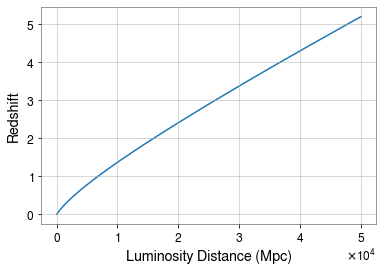

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1 * cost1 + a2 * q * cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)

luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

In [3]:
List = []

### Spin Parameters vs Detectability

In [4]:
vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'

f = h5py.File(vt_file, 'r')

Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
Ndraw = f.attrs['total_generated']
m1 = np.array(f['injections/mass1_source'])
m2 = np.array(f['injections/mass2_source'])
q = np.array(m2/m1)
z = np.array(f['injections/redshift'])
s1z = np.array(f['injections/spin1z'])
s2z = np.array(f['injections/spin2z'])
p_draw = np.array(f['injections/sampling_pdf'])
gstlal_ifar = np.array(f['injections/ifar_gstlal'])
pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])

ichi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
ichi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))

ifar_threshold = 1

found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))

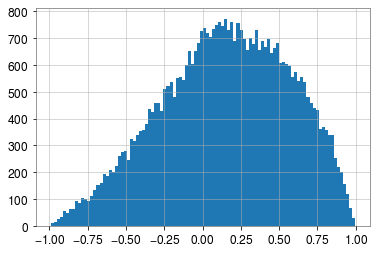

In [5]:
plt.hist(ichi_eff[found], bins = 100)
plt.show()

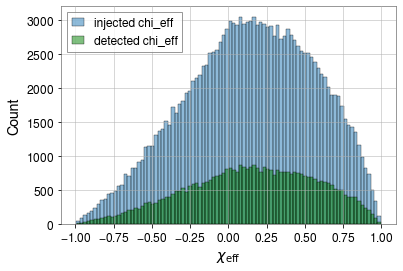

In [6]:
sns.histplot(ichi_eff, bins = 90, alpha =0.5, label = "injected chi_eff")
sns.histplot(ichi_eff[found], bins = 90, alpha =0.5, color = "green", label = "detected chi_eff")
plt.xlabel("$\chi_{\mathrm{eff}}$")
plt.legend()
plt.show()

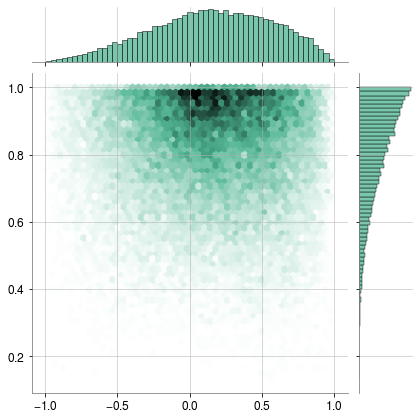

In [8]:
x = ichi_eff[found]
y = q[found]

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")
plt.show()

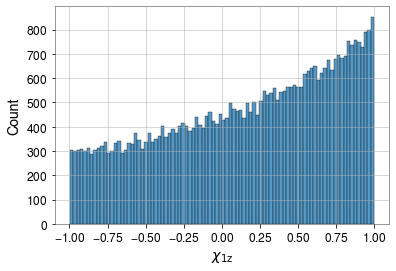

In [32]:
sns.histplot(s1z[found], bins = 90)
plt.xlabel("$\chi_{\mathrm{1z}}$")
plt.show()

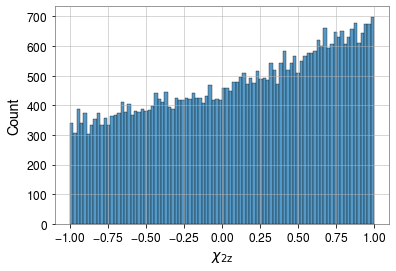

In [34]:
sns.histplot(s2z[found], bins = 90)
plt.xlabel("$\chi_{\mathrm{2z}}$")
plt.show()

## Selection Effects

In [2]:
from gwpopulation.models.redshift import _Redshift, total_four_volume

class _BaseVT(object):
    def __init__(self, model, data):
        self.data = data
        if isinstance(model, list):
            model = Model(model)
            print("1")
        elif not isinstance(model, Model):
            model = Model([model])
            print("2")
        self.model = model

    def __call__(self, *args, **kwargs):
        raise NotImplementedError


class GridVT(_BaseVT):
    """
    Evaluate the sensitive volume on a grid.
    Parameters
    ----------
    model: callable
        Population model
    data: dict
        The sensitivity labelled `vt` and an entry for each parameter to be marginalized over.
    """

    def __init__(self, model, data):
        self.vts = data.pop("vt")
        super(GridVT, self).__init__(model=model, data=data)
        self.values = {key: xp.unique(self.data[key]) for key in self.data}
        shape = np.array(list(self.data.values())[0].shape)
        lens = {key: len(self.values[key]) for key in self.data}
        self.axes = {int(np.where(shape == lens[key])[0]): key for key in self.data}
        self.ndim = len(self.axes)

    def __call__(self, parameters):
        self.model.parameters.update(parameters)
        vt_fac = self.model.prob(self.data) * self.vts
        for ii in range(self.ndim):
            vt_fac = trapz(vt_fac, self.values[self.axes[self.ndim - ii - 1]], axis=-1)
        return vt_fac


class ResamplingVT(_BaseVT):
    """
    Evaluate the sensitive volume using a set of found injections.
    See https://arxiv.org/abs/1904.10879 for details of the formalism.
    Parameters
    ----------
    model: callable
        Population model
    data: dict
        The found injections and relevant meta data
    n_events: int
        The number of events observed
    """

    def __init__(self, model, data, n_events=np.inf):
        super(ResamplingVT, self).__init__(model=model, data=data)
        self.n_events = n_events
        self.total_injections = data.get("total_generated", len(data["prior"]))
        self.analysis_time = data.get("analysis_time", 1)
        self.redshift_model = None
        for _model in self.model.models:
            if isinstance(_model, _Redshift):
                self.redshift_model = _model
        if self.redshift_model is None:
            self._surveyed_hypervolume = total_four_volume(
                lamb=0, analysis_time=self.analysis_time
            )

    def __call__(self, parameters):
        """
        Compute the expected number of detections given a set of injections.
        This should be implemented as in https://arxiv.org/abs/1904.10879
        If n_effective < 4 * n_events we return np.inf so that the sample
        is rejected.
        Parameters
        ----------
        parameters: dict
            The population parameters
        """
        mu, var = self.detection_efficiency(parameters)
        new_row = [mu, var, parameters["alpha"], parameters["beta"], parameters["mmin"], parameters["mmax"],
                   parameters["mu_chi_eff"], parameters["sigma_chi_eff"], 
                   parameters["mu_chi_p"], parameters["sigma_chi_p"], parameters["spin_covariance"]]
        List.append(new_row)
        
        if mu ** 2 <= 4 * self.n_events * var:
            return np.inf
        n_effective = mu ** 2 / var
        vt_factor = mu / np.exp((3 + self.n_events) / 2 / n_effective)
        return vt_factor

    def detection_efficiency(self, parameters):
        self.model.parameters.update(parameters)
        weights = self.model.prob(self.data) / self.data["prior"]
        mu = float(xp.sum(weights) / self.total_injections)
        var = float(
            xp.sum(weights ** 2) / self.total_injections ** 2
            - mu ** 2 / self.total_injections
        )
        return mu, var

    def surveyed_hypervolume(self, parameters):
        r"""
        The total surveyed 4-volume with units of :math:`Gpc^3yr`.
        .. math::
            \mathcal{V} = \int dz \frac{dV_c}{dz} \frac{\psi(z)}{1 + z}
        If no redshift model is specified, assume :math:`\psi(z)=1`.
        Parameters
        ----------
        parameters: dict
            Dictionary of parameters to compute the volume at
        Returns
        -------
        float: The volume
        """
        if self.redshift_model is None:
            return self._surveyed_hypervolume
        else:
            return (
                self.redshift_model.normalisation(parameters) / 1e9 * self.analysis_time
            )

### Check for zero spins

In [9]:
vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'

f = h5py.File(vt_file, 'r')
s1z = np.array(f['injections/spin1z'])
s2z = np.array(f['injections/spin2z'])
ii = 0
jj = 0

for i in range(len(s1z)):
    if s1z[i]==0:
        ii = ii+1
for j in range(len(s1z)):
    if s1z[j]==0:
        jj = jj+1
        
print(ii, jj)

print(min(abs(s1z)), min(abs(s2z)))
# print(list(ff.keys()))
# print(list(ff['injections'].keys()))
# print(list(ff.attrs.items()))

0 0
2.2380752398021286e-06 1.7086450725400937e-06


In [5]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    pmass = np.array(m1**(-2.35+1) * q**2)
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])

    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        pchieff = xp.asarray(pchieff[found]),
        pmass = xp.asarray(pmass[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"]

    return ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"] * data["pchieff"]

    return ResamplingVT(model = model, data = data, n_events = 44)

In [6]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff, 
                      mass.power_law_primary_mass_ratio])
    vt_func = injection_resampling_vt_spin_mass
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

19:13 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


## Test

In [7]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [8]:
par = priors.sample(100000)
par = pd.DataFrame.from_dict(par)
par

,alpha,beta,mmin,mmax,mu_chi_eff,sigma_chi_eff,mu_chi_p,sigma_chi_p,spin_covariance
0,-2.2,1.3,5.0,75.0,-0.459416,0.767869,0.344753,0.220449,0.347420
1,-2.2,1.3,5.0,75.0,0.156545,0.088784,0.435082,0.426233,-0.083155
2,-2.2,1.3,5.0,75.0,-0.396184,0.821520,0.541025,0.539434,0.310638
3,-2.2,1.3,5.0,75.0,0.306710,0.538850,0.957722,0.356389,-0.415052
4,-2.2,1.3,5.0,75.0,-0.746081,0.705397,0.221681,0.967842,-0.149710
...,...,...,...,...,...,...,...,...,...
99995,-2.2,1.3,5.0,75.0,0.761596,0.462865,0.195127,0.155070,0.670369
99996,-2.2,1.3,5.0,75.0,-0.128533,0.809632,0.142405,0.524355,0.319716
99997,-2.2,1.3,5.0,75.0,-0.347720,0.118730,0.841333,0.695339,0.146975
99998,-2.2,1.3,5.0,75.0,-0.751039,0.440755,0.434853,0.020245,0.726826


In [9]:
# for i in range(len(par)):
#     print(par.loc[i,:])
#     break;

In [10]:
# par = priors.sample(1000)
# for i in par.items():
#     print(i[1][0])

In [11]:
for i in range(len(par)):
    ans = selection_function(par.loc[i,:])

In [12]:
# print(List)

In [13]:
a = np.array(List)

In [14]:
result_df = pd.DataFrame()

result_df["mu"] = a[:,0]
result_df["var"] = a[:,1]
result_df["alpha"] = a[:,2]
result_df["beta"] = a[:,3]
result_df["mmin"] = a[:,4]
result_df["mmax"] = a[:,5]
result_df["mu_chi_eff"] = a[:,6]
result_df["sigma_chi_eff"] = a[:,7]
result_df["mu_chi_p"] = a[:,8]
result_df["sigma_chi_p"] = a[:,9]
result_df["spin_covariance"] = a[:,10]
result_df["acceptance"] = False 

for ii in range(len(result_df)):
    if result_df["mu"][ii]**2 >= 4 * 44 * result_df["var"][ii]:
        result_df["acceptance"][ii] = True
    else:
        result_df["acceptance"][ii] = False
        
result_df.to_csv("inj_spin_mass.csv", index=False)

<ipython-input-14-c926482898ab>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["acceptance"][ii] = True
<ipython-input-14-c926482898ab>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["acceptance"][ii] = False


In [15]:
j = 0
for i in range(len(result_df)):
    if result_df["acceptance"][i] == False:
        j=j+1
print(j, len(result_df))

2311 100000


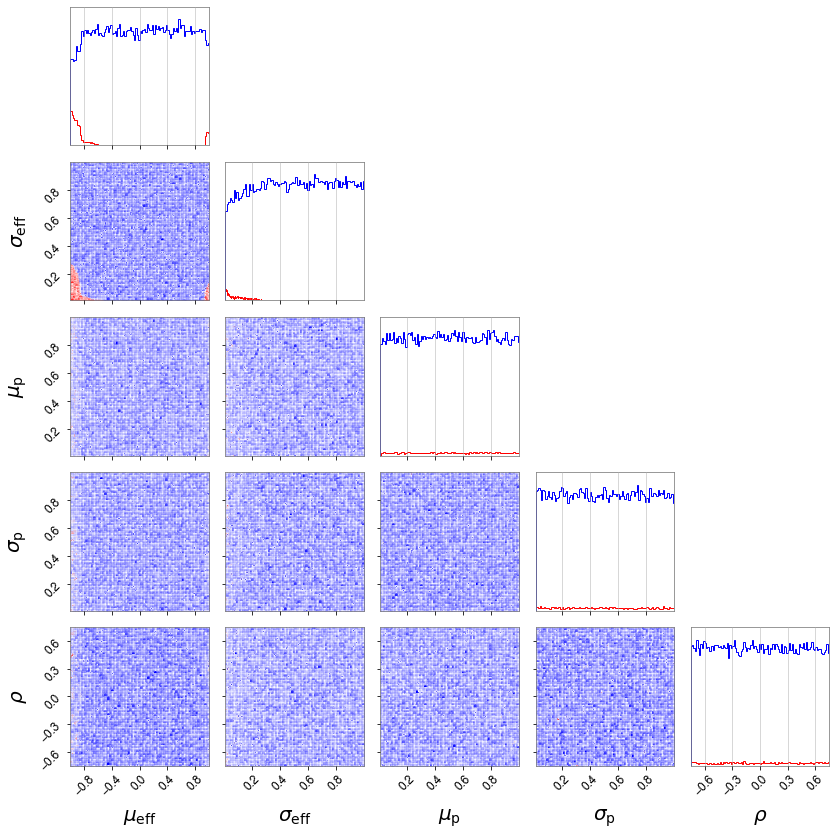

In [16]:
params = ["mu_chi_eff", "sigma_chi_eff", "mu_chi_p", "sigma_chi_p", "spin_covariance"]
labels = ["$\\mu_{\mathrm{eff}}$", "$\\sigma_{\mathrm{eff}}$", 
          "$\\mu_{\mathrm{p}}$", "$\\sigma_{\mathrm{p}}$", "$\\rho$"]

data1 = result_df.loc[(result_df["acceptance"] == False), params].values
data2 = result_df.loc[(result_df["acceptance"] == True), params].values

fig = corner.corner(data1, color="red",bins = 100, label_kwargs=dict(fontsize=20), plot_contours =False,
                    plot_datapoints=True, labels=labels)
corner.corner(data2, color="blue", bins = 100, label_kwargs=dict(fontsize=20),plot_contours = False,
              plot_datapoints=True, labels=labels, fig=fig)

plt.tight_layout()
plt.show()